In [73]:
# External libraries used for data handling:
import os
import warnings
import pandas as pd
from datetime import datetime
from dateutil import parser
import pickle
%pylab inline
# Packages for LDA
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary, MmCorpus
import pyLDAvis # LDA visualisation
import pyLDAvis.gensim
# Helper functions
from lda_helper import *

Populating the interactive namespace from numpy and matplotlib


/Users/robin/anaconda3/envs/ada/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [385]:
# df = pd.read_csv('df_1934_to_1998_JDG.csv')
# df = pd.read_csv('df_1826_to_1874_JDG.csv')
df = pd.read_csv('df_GDL_all.csv')
df2 = pd.read_csv('df_JDG_all.csv')
df = df.append(df2)
df.reset_index(inplace=True)

# parsing all text to strings
df.text=df.text.apply(lambda x: str(x))
# parsing the strings in 'date' column to a pandas Timestamp
df.date = df.date.apply(lambda x: parser.parse(x))

In [400]:
df=df.drop(['index','Unnamed: 0', 'Unnamed: 0.1'],axis=1)
df.head()

,date,newspaper,text,year,month
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,02
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,02
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,02
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,03
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,03


In [386]:
df_new.shape

(359038, 10)

In [390]:
# adding a year and month column
df_new = pd.DataFrame(columns=['year', 'month'])
df_new.year = df.date.apply(lambda x: datetime.strftime(x, '%Y'))
df_new.month = df.date.apply(lambda x: datetime.strftime(x, '%m'))
df = df.join(df_new, how='outer')

In [392]:
df.to_csv('df_all_merged.csv')

In [393]:
type(df.date[0])
# Selection of articles between dates can be done like so:
# df.date = df.date.apply(lambda x: parser.parse(x))
# df.set_index=('date', inplace=True)
# df[datetime(1851,1,24):datetime(1852,8,22)]

pandas._libs.tslib.Timestamp

# Latent Dirchlet Allocation
The following files are created during this section and can be loaded to resume from a previous point:
* dico.pickle
* corpus.mm
* lda_model_all
* lda_model_all.id2word  
* lda_model_all.expElogbeta.npy 
* lda_model_all.state
* LDAvis_prepared

In [71]:
project_path = '/Users/robin/GIT/ADA/ADA2017_GroupWork/Project_temp/10_topics_vis/'
dico_fp = os.path.join(project_path, 'dico.pickle')
lda_model_filepath = os.path.join(project_path, 'lda_model_all')
ldavis_path = os.path.join(project_path, 'LDAvis_prepared')

In [ ]:
# learn the dictionnary by iterating over all of the articles
dico = Dictionary([article.split() for article in df.text.tolist()])

# filter tokens that are very rare or too common from
# the dictionary. Here we decided to keep all unusual tokens that
# may appear in only one document, but to discard those that are in 
# 40% or more of the corpus
dico.filter_extremes(no_below=0, no_above=0.4)

# reassign integer lda
dico.compactify()
# save dictionary
dico.save(dico_fp)

In [395]:
# load dictionary
dico = Dictionary.load(dico_fp)

In [ ]:
# generate bag-of-word representations for
# all reviews and save them as a matrix

# BoW is saved to file 'corpus.mm'
MmCorpus.serialize(os.path.join(project_path, 'corpus.mm'),
                       bow_generator(df.text.tolist(), dico))  

In [396]:
# load bow_corpus from file
bow_corpus = MmCorpus(os.path.join(project_path, 'corpus.mm'))

In [ ]:
len(bow_corpus)

In [ ]:
# Generating and storing the LDA model
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(bow_corpus,
                       num_topics=10,
                       id2word=dico,
                       workers=3)
    # saving the LDA model to disk 
    lda.save(lda_model_filepath)

In [397]:
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus, dico)

In [ ]:
# saving LDAvis_prepared
with open(ldavis_path, 'wb') as file:
    pickle.dump(LDAvis_prepared, file)

In [74]:
# loading LDAvis_prepared
with open(ldavis_path, 'rb') as file:
    LDAvis_prepared = pickle.load(file)

In [75]:
pyLDAvis.display(LDAvis_prepared)

## Todo
* exporting graphics from pyLDAvis
* time distribution of topics -> see if we can pick out any trends
* time distribution (year) of all votation articles
* comparison of GDL vs JDG
* seasonal comparison, ie. a on a month-to-month basis

# Data analysis: votations through time
We would now like to extract the topic distribution of each article into a `DataFrame` and join this to our main `DataFrame`. In this way we can make plots of the evolution of different topics throughout time.

The column titles correspond to the topic in question and the values are
the coefficient of each topic

In [ ]:
# ! Time consuming
df_new = pd.DataFrame()
for bow in bow_corpus:
    rk = lda.get_document_topics(bow, minimum_probability=0)
    ziped = [p[1] for p in rk]
    df_topicscore = pd.DataFrame(ziped)
    df_topicscore = df_topicscore.transpose()
    df_new = df_new.append(df_topicscore)

In [403]:
# Saving df
# df_new.to_csv('df_new_topics.csv')
# Loading df
df_new=pd.read_csv('df_new_topics.csv')

In [460]:
df_new = df_new.drop(['Unnamed: 0'],axis=1)
df_new.columns = range(1, lda.num_topics+1)
df_new.head()

,1,2,3,4,5,6,7,8,9,10
0,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


In [2]:
# df = df.join(df_new)
# Saving df
# df.to_csv('df_merged_with_topics.csv')
df = pd.read_csv('df_merged_with_topics.csv')

In [3]:
df.head()

,Unnamed: 0,date,newspaper,text,year,month,1,2,3,4,5,6,7,8,9,10
0,0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,2,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,2,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,2,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,3,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,3,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


## Grouping by year
In order to reduce the size of our data a bit, let us start with grouping by year and looking at the evolution of topics on a year-by-year basis. We will sum all the topic distributions within one year, giving an estimate of the number of articles that are uniquely about one topic. Note that this is a slightly artificial number, as articles are estimated as linear combinations of different topics. By summing these numbers, it assumes that two articles that are each 50% about the same topic equate to one article that is purely about this topic.

In [531]:
df_year = pd.DataFrame(columns=df.columns[5:])
# years=['1798','1799']
counts =[]
for year in df.year.unique():
    counts.append(df[df['year']==year].shape[0])
    df_year = df_year.append(df[df['year']==year][df.columns[5:]].sum(), ignore_index=True)
    
df_year = df_year.join(pd.DataFrame(df.year.unique(), columns=['year']))
df_year = df_year.join(pd.DataFrame(counts, columns=['counts']))

In [69]:
# df_year.to_csv('df_year.csv')
df_year = pd.read_csv('df_year.csv')
df_year=df_year.drop(['Unnamed: 0'],axis=1)
df_year.head()

,1,2,3,4,5,6,7,8,9,10,year,counts
0,3.958967,3.146256,1.021573,28.808147,8.954548,2.313283,1.429564,1.930682,8.780999,3.655979,1798,64
1,3.768399,2.437451,1.731562,36.056378,11.959376,2.269571,2.499613,3.197872,17.159302,5.920475,1799,87
2,1.506957,1.439380,3.874369,29.171824,6.548554,0.424034,2.064513,3.959840,6.422050,3.588480,1804,59
3,1.240842,1.463806,3.742487,27.212729,6.833798,0.293878,1.956866,3.769437,3.173549,3.312608,1805,53
4,1.186595,1.712533,3.558427,11.499375,4.143798,0.275740,2.415227,1.614110,2.565243,1.028952,1806,30


In the following graph we can get an overview of the number of articles we have over the course of the years. It doesn't come as much surprise that the recent years have a lot more articles, with the exception being 1998. This is due to the dataset ending in February 1998, and thus it not being a complete year. In order to have a better estimate about how topics are changing throughout the years we will therefore normalise with the counts, or the number of articles in that year. We can also notice what could potentially be holes in the data, where the numbers of articles is significantly lowering than neighbouring years. These two holes, which occur roughly 120 and 140 years after the beginning of the data collection also coincide roughly with the first and second world wars respectively. It is therefore not a huge surprise that fewer articles were published at the time.

Based on this we should also take the very early years with a grain of salt, as there are relatively very few articles in roughly the first 25 years of data

Text(0,0.5,'# of Articles')

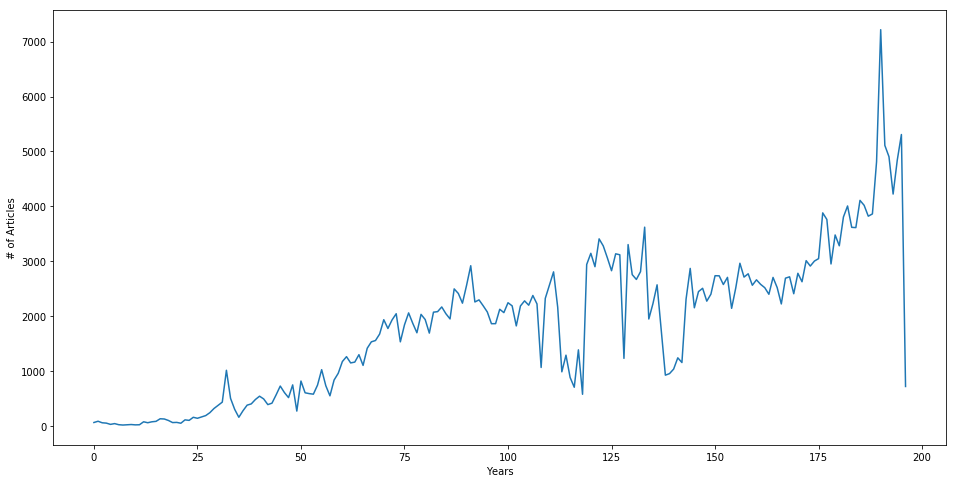

In [67]:
ax = df_year.counts.plot(kind='line', figsize=(16,8))
ax.set_xlabel('Years')
ax.set_ylabel('# of Articles')

In [28]:
topic_cols=['1','2','3','4','5','6','7','8','9','10']
df_year.counts = df_year.counts.astype('int')
df_year[topic_cols] = df_year[topic_cols].astype('float')
for i in topic_cols:
    df_year[i] = df_year[i]/df_year.counts

In [29]:
df_year.head()

,1,2,3,4,5,6,7,8,9,10,year,counts
0,0.061859,0.049160,0.015962,0.450127,0.139915,0.036145,0.022337,0.030167,0.137203,0.057125,1798,64
1,0.043315,0.028017,0.019903,0.414441,0.137464,0.026087,0.028731,0.036757,0.197233,0.068051,1799,87
2,0.025542,0.024396,0.065667,0.494438,0.110992,0.007187,0.034992,0.067116,0.108848,0.060822,1804,59
3,0.023412,0.027619,0.070613,0.513448,0.128940,0.005545,0.036922,0.071121,0.059878,0.062502,1805,53
4,0.039553,0.057084,0.118614,0.383313,0.138127,0.009191,0.080508,0.053804,0.085508,0.034298,1806,30


Now we may plot the relative number of articles that are in relation to direct democracy keywords. In this case we can pick 'référendum' and 'initiative' as two representative words. If we look back at our `pyLDAvis` plot we can see that both topic 4 and 8 have a very high frequency of both these terms compared to other topics. While 5 and 10 have rather high frequency of only 'référendum' compared to other topics

Text(0,0.5,'# of Articles')

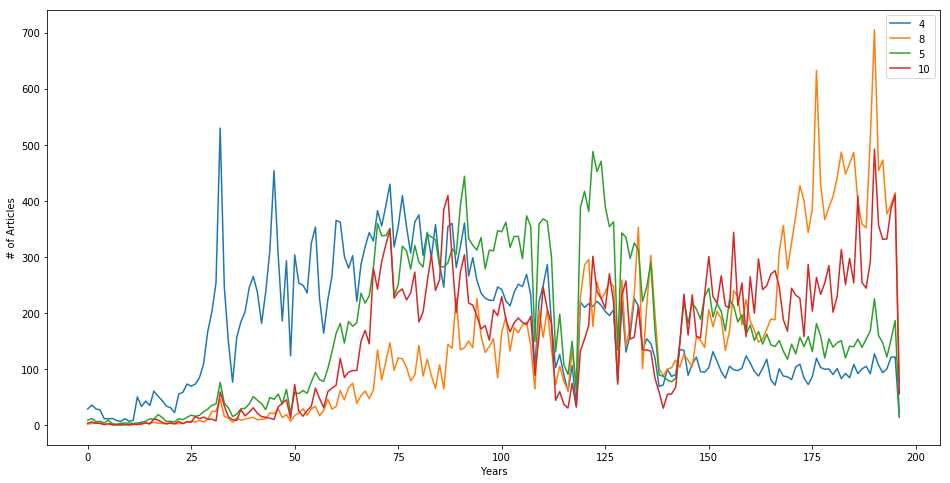

In [68]:
ax = df_year['4'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['8'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['5'].plot(kind='line', figsize=(16,8), legend=True)
ax = df_year['10'].plot(kind='line', figsize=(16,8), legend=True)
ax.set_xlabel('Years')
ax.set_ylabel('# of Articles')


In these 4 cases it doesn't appear that there are continuing declines or increases. Rather there is sometimes very sharp increases on occasion, these may be correlated to a very hot current topic that is written about profusely. 

## Grouping by Month
In this case the idea is to repeat the previous analysis, but rather to group by month and see if we can observe any seasonal patterns.